# CREACIO DE L'AGENT EVALUADOR DE LA RUTA

In [110]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb

In [217]:
data = pd.read_json("C:/Users/FX517/OneDrive - Universitat Politècnica de Catalunya/Escritorio/UPC/5e Quatrimestre/SBC/PRACITCA 2/SBC_2/data/base_de_dades_final.json")
artworks_data = pd.read_csv("C:/Users/FX517/OneDrive - Universitat Politècnica de Catalunya/Escritorio/UPC/5e Quatrimestre/SBC/PRACITCA 2/SBC_2/artworks_data/artworks_final.csv")

## LGB

In [201]:
interessos_estils = artworks_data['Style'].unique().tolist()

companyia = [
    "alone", "group"
]

interessos_types = artworks_data['Classification'].unique().tolist()

# Creem una columna binària per cada estil
for estil in interessos_estils:
    data[f'estil_{estil}'] = data['visitant_interessos_estils'].apply(lambda x: 1 if estil in x else 0)

# Creem una columna binària per cada companyia
for comp in companyia:
    data[f'companyia_{comp}'] = data['visitant_companyia'].apply(lambda x: 1 if comp in x else 0)

# Creem una columna binària per cada tipus d'interès
for tipus in interessos_types:
    data[f'interes_{tipus}'] = data['visitant_interessos_tipus'].apply(lambda x: 1 if tipus in x else 0)

# convertim la columna visitant_estudis a binaria
data['visitant_estudis'] = data['visitant_estudis'].apply(lambda x: 1 if x else 0)

data['temps_total'] = data['visitant_dies'] * 24 + data['visitant_hores']

data = data.drop(columns=['visitant_interessos_estils', 'visitant_interessos_autor', 
                                      'visitant_companyia', 'visitant_interessos_tipus',
                                      'visitant_dies', 'visitant_hores'])

In [95]:
data.dtypes

visitante_id                      int64
visitant_edat                     int64
visitant_visites                  int64
visitant_dies                     int64
visitant_hores                    int64
visitant_estudis                  int64
visitant_coneixement              int64
visitant_quizz                    int64
ruta                             object
ruta_quadres                     object
ruta_temps                        int64
puntuacio_ruta                    int64
estil_Surrealismo                 int64
estil_Cubismo                     int64
estil_Pop Art                     int64
estil_Expresionismo Abstracto     int64
estil_Postmodernismo              int64
estil_Impresionismo               int64
estil_Realismo                    int64
estil_Arte Contemporáneo          int64
estil_Romanticismo                int64
companyia_alone                   int64
companyia_group                   int64
interes_Print                     int64
interes_Drawing                   int64


In [195]:
# Normalitzem les dades numèriques
cols_to_compare = data.select_dtypes(include=['int64']).columns.to_list()

# extreure las columnas visitant_id
cols_to_compare.remove('visitante_id')
cols_to_compare.remove('ruta_temps')

# data_normalized = data[cols_to_compare].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# print(data_normalized.columns)
# print(data_normalized)

# keep the cols_to_compare
data = data[cols_to_compare]

In [196]:
X = data.drop(columns=['puntuacio_ruta'])  # Asegúrate de tener la columna 'feedback'
y = data['puntuacio_ruta']

# 3. División en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Preparar el Dataset para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

## Train

In [197]:
# 5. Configuración de los parámetros para regresión
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 50,  # Aumenta el número de hojas (más capacidad de aprendizaje)
    'max_depth': 7,  # Permite que los árboles sean más profundos
    'learning_rate': 0.01,  # Reduce la tasa de aprendizaje para ajustes más finos
    'feature_fraction': 0.8,  # Reduce ligeramente las features por árbol (mejora generalización)
    'bagging_fraction': 0.8,  # Submuestreo de filas
    'bagging_freq': 5,  # Cada 5 iteraciones
    'lambda_l1': 1.0,  # Regularización L1 para evitar sobreajuste
    'lambda_l2': 1.0,  # Regularización L2
    'min_data_in_leaf': 20  # Reduce el tamaño mínimo de datos en una hoja
}

# 6. Entrenamiento del modelo
model = lgb.train(
    params,
    train_data,
    valid_sets=[train_data, test_data],
    num_boost_round=1000,
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 785, number of used features: 22
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 2.514650
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [198]:
# 7. Predicciones
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

# 8. Evaluación del modelo
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")

RMSE: 1.4771


C:\Users\FX517\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

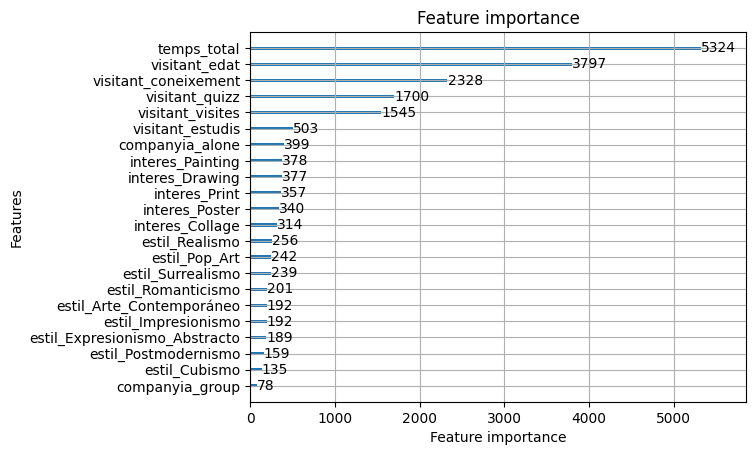

In [199]:
lgb.plot_importance(model)


Mirem la desviacio std de la puntuacio de la ruta per veure com de bona es la prediccio del model

In [102]:
data['puntuacio_ruta'].describe()

count    982.000000
mean       2.518330
std        1.379613
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: puntuacio_ruta, dtype: float64

## CatBoosting

In [218]:
# Normalitzem les dades numèriques
# cols_to_compare = data.select_dtypes(include=['int64']).columns.to_list()
cols_to_compare = data.columns.to_list()

# extreure las columnas visitant_id
cols_to_compare.remove('visitante_id')
cols_to_compare.remove('ruta')
cols_to_compare.remove('ruta_quadres')
cols_to_compare.remove('ruta_temps')
cols_to_compare.remove('visitant_interessos_autor')

# keep the cols_to_compare
data = data[cols_to_compare]

data['temps_total'] = data['visitant_dies'] * 24 + data['visitant_hores']

data = data.drop(columns=['visitant_dies', 'visitant_hores'])

In [219]:
X = data.drop(columns=['puntuacio_ruta'])  # Asegúrate de tener la columna 'feedback'
y = data['puntuacio_ruta']

# 3. División en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [221]:
for col in X_train.columns:
    if X_train[col].apply(lambda x: isinstance(x, list)).any():
        print(col)

X_train['visitant_interessos_estils'] = X_train['visitant_interessos_estils'].apply(lambda x: x[0] if isinstance(x, list) else x)
X_test['visitant_interessos_estils'] = X_test['visitant_interessos_estils'].apply(lambda x: x[0] if isinstance(x, list) else x)

X_train['visitant_interessos_tipus'] = X_train['visitant_interessos_tipus'].apply(lambda x: x[0] if isinstance(x, list) else x)
X_test['visitant_interessos_tipus'] = X_test['visitant_interessos_tipus'].apply(lambda x: x[0] if isinstance(x, list) else x)


visitant_interessos_estils
visitant_interessos_tipus


In [222]:
from catboost import CatBoostRegressor

cat_features = data.select_dtypes(include=['object', 'bool']).columns.to_list()

model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    l2_leaf_reg=3,
    loss_function='RMSE',
    eval_metric='RMSE',
    early_stopping_rounds=50,
    verbose=100
)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

0:	learn: 1.3635260	test: 1.4164516	best: 1.4164516 (0)	total: 14.8ms	remaining: 14.8s
100:	learn: 1.2096150	test: 1.4050149	best: 1.4048415 (95)	total: 1.72s	remaining: 15.3s
200:	learn: 1.0986196	test: 1.4033032	best: 1.4021140 (193)	total: 3.43s	remaining: 13.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.399310909
bestIteration = 232

Shrink model to first 233 iterations.


In [223]:
# 7. Predicciones
y_pred = model.predict(X_test)

# 8. Evaluación del modelo
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse:.4f}")

RMSE: 1.3993


C:\Users\FX517\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [224]:
data['puntuacio_ruta'].describe()

count    982.000000
mean       2.518330
std        1.379613
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: puntuacio_ruta, dtype: float64

In [225]:
# print the feature importance
importances = model.get_feature_importance(prettified=True)


In [226]:
importances 

,Feature Id,Importances
0,visitant_interessos_tipus,19.189452
1,visitant_interessos_estils,17.736689
2,visitant_coneixement,17.060778
3,temps_total,12.680623
4,visitant_quizz,8.874579
5,visitant_visites,8.329883
6,visitant_edat,7.469492
7,visitant_estudis,5.189734
8,visitant_companyia,3.468770


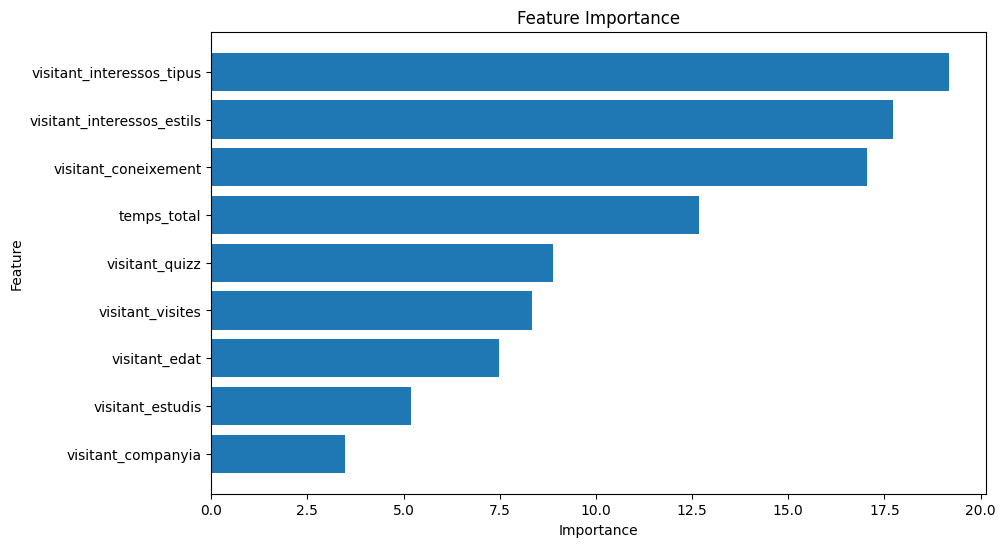

In [228]:
import matplotlib.pyplot as plt

importances = importances.sort_values(by='Importances', ascending=True)

# plot the feature importance with the most important on the top
plt.figure(figsize=(10, 6))
plt.barh(importances['Feature Id'], importances['Importances'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


## XGBOOST

In [165]:
interessos_estils = artworks_data['Style'].unique().tolist()

companyia = [
    "alone", "group"
]

interessos_types = artworks_data['Classification'].unique().tolist()

# Creem una columna binària per cada estil
for estil in interessos_estils:
    data[f'estil_{estil}'] = data['visitant_interessos_estils'].apply(lambda x: 1 if estil in x else 0)

# Creem una columna binària per cada companyia
data['companyia_alone'] = data['visitant_companyia'].apply(lambda x: 1 if comp=='alone' in x else 0)

# Creem una columna binària per cada tipus d'interès
for tipus in interessos_types:
    data[f'interes_{tipus}'] = data['visitant_interessos_tipus'].apply(lambda x: 1 if tipus in x else 0)

# convertim la columna visitant_estudis a binaria
data['visitant_estudis'] = data['visitant_estudis'].apply(lambda x: 1 if x else 0)

data['temps_total'] = data['visitant_dies'] * 24 + data['visitant_hores']

data = data.drop(columns=['visitant_interessos_estils', 'visitant_interessos_autor', 
                            'visitant_companyia', 'visitant_interessos_tipus',
                            'visitant_dies', 'visitant_hores',
                            'visitant_coneixement', 'visitant_quizz'])

In [166]:
# Normalitzem les dades numèriques
cols_to_compare = data.select_dtypes(include=['int64']).columns.to_list()

# extreure las columnas visitant_id
cols_to_compare.remove('visitante_id')
cols_to_compare.remove('ruta_temps')

# data_normalized = data[cols_to_compare].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# print(data_normalized.columns)
# print(data_normalized)

# keep the cols_to_compare
data = data[cols_to_compare]

In [167]:
X = data.drop(columns=['puntuacio_ruta'])  # Asegúrate de tener la columna 'feedback'
y = data['puntuacio_ruta']

# 3. División en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Preparar el Dataset para LightGBM
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [168]:
# 5. Configuración de los parámetros para el modelo
params = {
    'objective': 'reg:squarederror',  # Regresión
    'eval_metric': 'rmse',  # Métrica RMSE
    'max_depth': 7,  # Profundidad máxima de los árboles
    'learning_rate': 0.01,  # Tasa de aprendizaje
    'subsample': 0.8,  # Submuestreo de las filas
    'colsample_bytree': 0.8,  # Submuestreo de las columnas por árbol
    'lambda': 1.0,  # Regularización L2
    'alpha': 1.0,  # Regularización L1
    'n_estimators': 1000  # Número de iteraciones (árboles)
}

# 6. Entrenamiento del modelo
num_round = 1000  # Número de iteraciones
early_stopping_rounds = 50  # Número de rondas de parada temprana

bst = xgb.train(params, dtrain, num_boost_round=num_round, evals=[(dtest, 'test')], 
                early_stopping_rounds=early_stopping_rounds)

[0]	test-rmse:1.41551
[1]	test-rmse:1.41461
[2]	test-rmse:1.41439
[3]	test-rmse:1.41474
[4]	test-rmse:1.41460
[5]	test-rmse:1.41460
[6]	test-rmse:1.41439
[7]	test-rmse:1.41362
[8]	test-rmse:1.41316
[9]	test-rmse:1.41343
[10]	test-rmse:1.41310
[11]	test-rmse:1.41238
[12]	test-rmse:1.41196
[13]	test-rmse:1.41176
[14]	test-rmse:1.41217
[15]	test-rmse:1.41178
[16]	test-rmse:1.41126
[17]	test-rmse:1.41218
[18]	test-rmse:1.41225
[19]	test-rmse:1.41235
[20]	test-rmse:1.41224
[21]	test-rmse:1.41221
[22]	test-rmse:1.41289
[23]	test-rmse:1.41337
[24]	test-rmse:1.41358
[25]	test-rmse:1.41374
[26]	test-rmse:1.41416
[27]	test-rmse:1.41362
[28]	test-rmse:1.41460
[29]	test-rmse:1.41449
[30]	test-rmse:1.41454
[31]	test-rmse:1.41400
[32]	test-rmse:1.41405
[33]	test-rmse:1.41456
[34]	test-rmse:1.41424
[35]	test-rmse:1.41406
[36]	test-rmse:1.41422
[37]	test-rmse:1.41408
[38]	test-rmse:1.41397
[39]	test-rmse:1.41350
[40]	test-rmse:1.41344
[41]	test-rmse:1.41372
[42]	test-rmse:1.41377
[43]	test-rmse:1.4140

C:\Users\FX517\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [00:25:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [169]:
# 7. Predicciones
y_pred = bst.predict(dtest)

# 8. Evaluación del modelo (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 1.4127758361830367


C:\Users\FX517\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [136]:
data['puntuacio_ruta'].describe()

count    982.000000
mean       2.518330
std        1.379613
min        0.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: puntuacio_ruta, dtype: float64

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

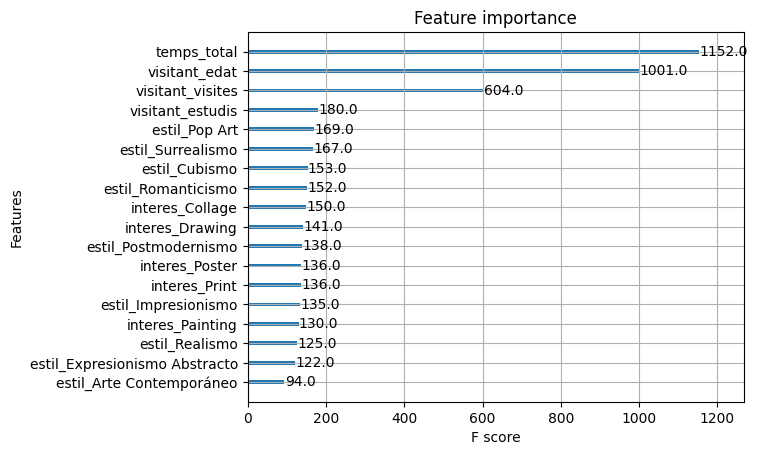

In [158]:
# print the importance of each feature
xgb.plot_importance(bst)

## GUARDAR MILLOR MODEL

Guardem CatBoost que ha estat el millor model

In [216]:
# Guardar el modelo
model.save_model('C:/Users/FX517/OneDrive - Universitat Politècnica de Catalunya/Escritorio/UPC/5e Quatrimestre/SBC/PRACITCA 2/SBC_2/CBR_ciclo/agent_model/best_catboost_model.cb')